In [2]:
#%pip install -qU langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import pandas as pd
import time

from langchain_core.prompts import ChatPromptTemplate
from src.utils import make_prompt, make_samples_from_df, plot_confusion_matrix
from src.service_model import LlmServiceModel

## load dataset

In [8]:
splits = {'train': 'data/train-00000-of-00001-7b34565378f02992.parquet', 'val': 'data/val-00000-of-00001-d7338c59b5e5031f.parquet', 'test': 'data/test-00000-of-00001-c830a979da438bff.parquet'}
df_train = pd.read_parquet("hf://datasets/PrevenIA/spanish-suicide-intent/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/PrevenIA/spanish-suicide-intent/" + splits["val"])

'HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Read timed out.' thrown while requesting GET https://huggingface.co/datasets/PrevenIA/spanish-suicide-intent/resolve/main/data/train-00000-of-00001-7b34565378f02992.parquet
Retrying in 1s [Retry 1/5].


## sampled data from validation dataset

In [9]:
n_samples = 200
df_label_1 = df_val[df_val["Label"] == 1].sample(n_samples, random_state=42)
df_label_0 = df_val[df_val["Label"] == 0].sample(n_samples, random_state=42)

df_val_sampled = pd.concat([df_label_1, df_label_0])
df_val_sampled

,Text,Label,dataset,__index_level_0__
1404,"La muerte parece amable, la soledad realmente ...",1,SuicideWatch,71947
10996,te quiero al final de mi vida\r\nQuiero ver tu...,1,TwitterSuicidalAnalysis,21733
10271,mi MC está actualmente encarcelado y en una má...,1,TwitterSuicidalAnalysis,4326
2490,Tengo 21 años y nunca he tenido una relación a...,1,SuicideWatch,2215
14492,"No tengo hogar, tengo una casa en la que vivo,...",1,Ghosh et al. 2023,1267
...,...,...,...,...
6430,Mi GF quiere tener cosas íntimas conmigo la se...,0,SuicideWatch,71613
14993,Largo. Vivir. Vida,0,Suicidal Tweet Detection Dataset,479
9879,¿Qué es 2846 x 3856 - (628 x 27) Ganador obtie...,0,SuicideWatch,5734
5770,Opinión impopular Esta es una opinión popular,0,SuicideWatch,36142


## create the samples for few shot prompting

In [10]:
samples = make_samples_from_df(df_train, n_samples = 10)
print(samples)

"texto: la escuela y el hogar me dan ganas de terminar con mi vida. Soy un autista de alto funcionamiento de 14 años con TDAH severo y ansiedad y trastorno del procesamiento sensorial, y vivo en una ciudad remota, en ninguna parte, con aproximadamente 1000 habitantes, 1 sistema escolar y una madre abusiva que se niega a educarme en casa y trata de cambiar las cosas y dice que soy una persona abusiva, ella me golpea y me llama cosas como pedazo de mierda sin valor, nunca va a llegar a ser nada, basura humana, etc., tanto los maestros como los niños me acosan en la escuela y literalmente, todo el mundo me odia en esa escuela porque todos son primos putos y soy raro. Quiero morir si falto a la escuela. Tengo que preocuparme de que mi mamá regrese a casa y grite, me insulte, beba y me pegue cuando voy a la escuela. No hay paz, tengo que esconderme en mi habitación con un Chromebook de la escuela que desbloqueé, esto es muy agotador físicamente, por favor ayuda, solo quiero morir y ahorcarm

## llm model client chatgpt 3.5 turbo

In [5]:
model_deployment = "gpt-35-proyecto1" #"gpt-4o"
api_version = "2023-03-15-preview" #2023-03-15-preview
llm_client = LlmServiceModel(model_deployment, api_version)
llm = llm_client.llm

## create few shot prompt template 

In [11]:
system_msg = """Basado en los ejemplos: {samples}.
                Clasifica el comentario con 1 si hay ideación/comportamiento suicida; 0 en caso que no haya ideación/comportamiento suicida.
                Solo responde la etiqueta de la clasificación "0" o "1", es decir no respondas al comentario.
                comentario:"""
few_shot_prompt = ChatPromptTemplate.from_messages([("system", system_msg,),("human", "{text}"),])
SAMPLES = make_samples_from_df(df_train, n_samples = 10)

## apply clasification function to sampled dataset

In [7]:
chain = few_shot_prompt | llm
def generate_clasification(text):
    time.sleep(2) # temporizador para no sobrepasar los tokens por minuto
    try:
        response = chain.invoke(
            {
                "samples": SAMPLES,
                "text": text,
            }
        )
        return response.content.split("etiqueta: ")[-1]
    except Exception as e:
        print(e)
        return "-1"


In [8]:
# Aplicar la función a cada registro del DataFrame
df_val_sampled['llm_label'] = df_val_sampled['Text'].apply(generate_clasification)
df_val_sampled

Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400}}
Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400}}
Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please rea

,Text,Label,dataset,__index_level_0__,llm_label
1404,"La muerte parece amable, la soledad realmente ...",1,SuicideWatch,71947,1
10996,te quiero al final de mi vida\r\nQuiero ver tu...,1,TwitterSuicidalAnalysis,21733,"Lo siento, pero no puedo proporcionar la respu..."
10271,mi MC está actualmente encarcelado y en una má...,1,TwitterSuicidalAnalysis,4326,0
2490,Tengo 21 años y nunca he tenido una relación a...,1,SuicideWatch,2215,1
14492,"No tengo hogar, tengo una casa en la que vivo,...",1,Ghosh et al. 2023,1267,1
...,...,...,...,...,...
6430,Mi GF quiere tener cosas íntimas conmigo la se...,0,SuicideWatch,71613,0
14993,Largo. Vivir. Vida,0,Suicidal Tweet Detection Dataset,479,0
9879,¿Qué es 2846 x 3856 - (628 x 27) Ganador obtie...,0,SuicideWatch,5734,"Lo siento, pero no puedo responder a esa pregu..."
5770,Opinión impopular Esta es una opinión popular,0,SuicideWatch,36142,0


In [9]:
df_val_sampled.to_csv("data/ds_poc_gpt3.5.csv")

In [10]:
df_val_sampled["llm_label"].value_counts()

llm_label
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

/var/folders/0z/3s22b27525jc3bm0m923h36h3wg489/T/ipykernel_4443/3994791554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["llm_label"] = filtered_df["llm_label"].astype(int)


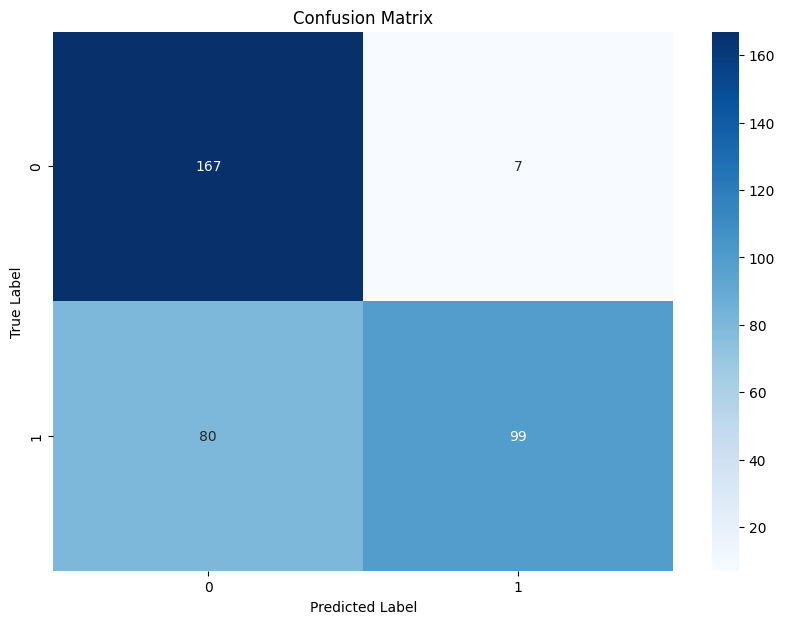

              precision    recall  f1-score   support

           0       0.68      0.96      0.79       174
           1       0.93      0.55      0.69       179

    accuracy                           0.75       353
   macro avg       0.81      0.76      0.74       353
weighted avg       0.81      0.75      0.74       353



In [11]:
# Filtrar las filas donde las predicciones son 0 o 1
filtered_df = df_val_sampled[df_val_sampled["llm_label"].isin(["0", "1"])]

filtered_df["llm_label"] = filtered_df["llm_label"].astype(int)

plot_confusion_matrix(filtered_df, 'Label', 'llm_label')

## llm model client chatgpt 4o-mini

In [12]:
model_deployment = "gpt-4o-mini"
llm_client = LlmServiceModel(model_deployment)
llm = llm_client.llm

## apply clasification function  to sampled dataset

In [13]:
chain = few_shot_prompt | llm

def generate_clasification(text):
    try: 
        response = chain.invoke(
            {
                "samples": SAMPLES,
                "text": text,
            }
        )
        time.sleep(1) # temporizador para no sobrepasar los tokens por minuto
        return response.content.split("etiqueta: ")[-1]
    except Exception as e:
        print(e)
        time.sleep(60)
        return "-1"

In [14]:
# Aplicar la función a cada registro del DataFrame
df_val_sampled['llm_label'] = df_val_sampled['Text'].apply(generate_clasification)
df_val_sampled

,Text,Label,dataset,__index_level_0__,llm_label
1404,"La muerte parece amable, la soledad realmente ...",1,SuicideWatch,71947,1
10996,te quiero al final de mi vida\r\nQuiero ver tu...,1,TwitterSuicidalAnalysis,21733,1
10271,mi MC está actualmente encarcelado y en una má...,1,TwitterSuicidalAnalysis,4326,0
2490,Tengo 21 años y nunca he tenido una relación a...,1,SuicideWatch,2215,1
14492,"No tengo hogar, tengo una casa en la que vivo,...",1,Ghosh et al. 2023,1267,1
...,...,...,...,...,...
6430,Mi GF quiere tener cosas íntimas conmigo la se...,0,SuicideWatch,71613,0
14993,Largo. Vivir. Vida,0,Suicidal Tweet Detection Dataset,479,0
9879,¿Qué es 2846 x 3856 - (628 x 27) Ganador obtie...,0,SuicideWatch,5734,0
5770,Opinión impopular Esta es una opinión popular,0,SuicideWatch,36142,0


In [15]:
df_val_sampled.to_csv("data/ds_poc_gpt40mini.csv")

In [16]:
df_val_sampled["llm_label"].value_counts()

llm_label
0                                                                                                                       268
1                                                                                                                       125
Un ordenador resuelve un crucigrama utilizando algoritmos y técnicas de procesamiento de lenguaje natural. Aquí           1
Para encontrar el valor de \( x \) en la expresión \( x + 4 = 10                                                          1
Para clasificar las características de un producto en principales y secundarias, primero es necesario tener la lista      1
Un blockchain es un sistema de registro digital descentralizado y seguro que almacena datos en bloques inter              1
1. Confundido\n2. Desconcertado\n3. Aturdido                                                                              1
Aquí tienes un código en Python para invertir una cadena:\n\n```python\ndef invertir_cadena(cadena                        

/var/folders/0z/3s22b27525jc3bm0m923h36h3wg489/T/ipykernel_5821/3994791554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["llm_label"] = filtered_df["llm_label"].astype(int)


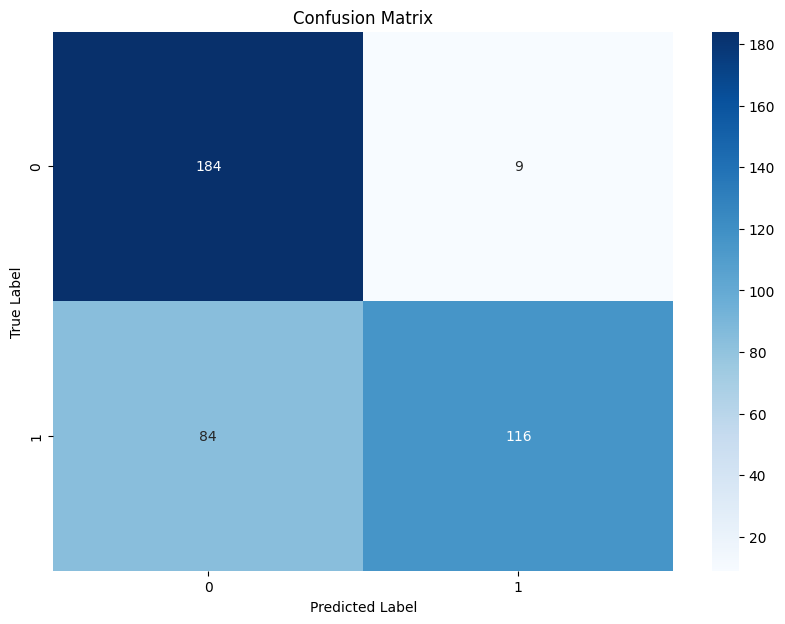

              precision    recall  f1-score   support

           0       0.69      0.95      0.80       193
           1       0.93      0.58      0.71       200

    accuracy                           0.76       393
   macro avg       0.81      0.77      0.76       393
weighted avg       0.81      0.76      0.76       393



In [18]:
# Filtrar las filas donde las predicciones son 0 o 1
filtered_df = df_val_sampled[df_val_sampled["llm_label"].isin(["0", "1"])]

filtered_df["llm_label"] = filtered_df["llm_label"].astype(int)

plot_confusion_matrix(filtered_df, 'Label', 'llm_label')